In [1]:
import collections
import itertools

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
from scipy import linalg
from scipy import stats

X_VALUES = [0, 1, 3]
MU = np.array([0.6, 3.6, np.nan, 6.8])


def simulate_data(n, random_seed=None):
    np.random.seed(random_seed)
    dist = stats.rv_discrete(values=list(zip(
        *[(x, 1/len(X_VALUES)) for x in X_VALUES])))
    x = dist.rvs(size=(n,))
    while len(np.unique(x)) == 1:
        x = dist.rvs(size=(n,))
    mu = MU[x]
    return x, stats.norm.rvs(loc=mu, scale=1)

def solve_beta_hat(x, y):
    X = np.column_stack((np.ones_like(x), x))
    return linalg.cho_solve(linalg.cho_factor(X.T.dot(X)), np.eye(X.shape[1])).dot(X.T).dot(y)

In [2]:
x, y = simulate_data(20, random_seed=2019)

In [3]:
beta_hat = solve_beta_hat(x, y)
beta_hat

array([1.07327318, 1.9097713 ])

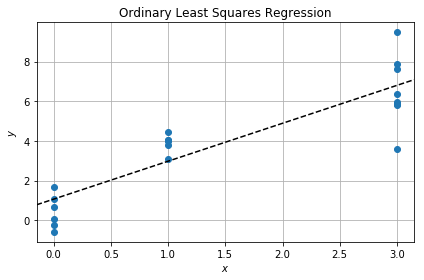

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
ax.grid(True)
ax.plot(x, y, 'o')
xlim_left, xlim_right = ax.get_xlim()
ax.plot([xlim_left, xlim_right],
        np.array([xlim_left, xlim_right])*beta_hat[1] + beta_hat[0], '--k')
ax.set_xlim(xlim_left, xlim_right);
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Ordinary Least Squares Regression')
fig.tight_layout()
fig.savefig('p1_ols.pdf', bbox_inches='tight')

In [5]:
def _estimate_beta1(n):
    x, y = simulate_data(n)    
    return solve_beta_hat(x, y)[1]

def estimate_beta1(num_estimates, n):    
    pool = multiprocessing.Pool(4)
    estimates = pool.map(_estimate_beta1, [n]*num_estimates)
    pool.close()
    return np.array(estimates)

def estimate_bias(num_trials):
    n_list = list(range(2, 31, 2)) + list(range(30, 101, 5))
    mean = []
    standard_errors = []
    for n in n_list:
        estimates = estimate_beta1(num_trials, n)
        mean.append(np.mean(estimates))
        standard_errors.append(np.sqrt(np.var(estimates, ddof=1)))
    return pd.DataFrame(collections.OrderedDict([
        ('$n$', n_list),
        ('$\\hat{\\beta}_1$', mean),
        ('$\\hat{\\sigma}$', standard_errors),
    ]))

#bias_simulations = estimate_bias(1000000)
#bias_simulations.to_pickle('p1_simulations.pkl')
bias_simulations = pd.read_pickle('p1_simulations.pkl')
bias_simulations

,$n$,$\hat{\beta}_1$,$\hat{\sigma}$
0,2,2.222531,1.115256
1,4,2.119261,0.752701
2,6,2.058301,0.536735
3,8,2.028134,0.408784
4,10,2.014462,0.332531
5,12,2.008274,0.284690
6,14,2.005376,0.253067
7,16,2.003600,0.231102
8,18,2.002070,0.213511
9,20,2.001587,0.200356


In [6]:
def partition(n, k = None, m = None):
    k = n if k is None else k
    m = n if m is None else m
    if m is None or m >= n:
        yield [n]
        
    for f in range(n-1 if m >= n else m, 0, -1):
        if f*(k - 1) < n - f:
            break
        for p in partition(n-f, k - 1, f):
            yield [f] + p
            

def multiset_permuation(xs):
    current_permutation = len(xs)*[None]
    counts = collections.Counter(xs)
    
    def yield_permuation(j):
        if j == len(xs):
            yield tuple(current_permutation)
            return
            
        for x in counts:
            if counts[x] <= 0:
                continue                
            counts[x] -= 1
            current_permutation[j] = x
            for permuation in yield_permuation(j + 1):
                yield permuation
            counts[x] += 1
    
    return yield_permuation(0)
            
def enumerate_multinomial_support(n, k):
    for p in partition(n, k):
        unordered_draw = [0]*(k - len(p)) + p
        for x in multiset_permuation(unordered_draw):
            yield x

In [7]:
def solve_expected_beta(n):
    support = enumerate_multinomial_support(n, 3)
    weighted_sum = np.zeros(2)
    total_prob = 0
    for sample in support:
        if np.isin(n, sample):
            continue        
        x = np.hstack([count*[X_VALUES[i]] for i, count in enumerate(sample)])
        y = MU[x.astype(np.int)]
        expected_beta = solve_beta_hat(x, y)
        prob = stats.multinomial.pmf(sample, n, p = np.ones(len(X_VALUES))/len(X_VALUES))
        weighted_sum += expected_beta*prob
        total_prob += prob
    return weighted_sum/total_prob

expected_beta = np.array([solve_expected_beta(n) for n in bias_simulations['$n$']])
expected_beta

array([[1.06666667, 2.22222222],
       [1.04168541, 2.11935822],
       [1.0336912 , 2.05765274],
       [1.02878485, 2.02807713],
       [1.02477543, 2.01456074],
       [1.02144138, 2.00820044],
       [1.01872191, 2.00502319],
       [1.01652181, 2.00331956],
       [1.01473662, 2.00233772],
       [1.01327484, 2.00173226],
       [1.01206379, 2.0013359 ],
       [1.01104808, 2.00106296],
       [1.01018608, 2.00086695],
       [1.00944647, 2.00072128],
       [1.00880554, 2.00060992],
       [1.00880554, 2.00060992],
       [1.00752558, 2.0004236 ],
       [1.00656859, 2.0003117 ],
       [1.00582669, 2.0002391 ],
       [1.00523495, 2.00018928],
       [1.0047521 , 2.00015359],
       [1.00435066, 2.00012714],
       [1.00401168, 2.00010698],
       [1.00372166, 2.00009128],
       [1.0034707 , 2.00007879],
       [1.00325143, 2.00006871],
       [1.0030582 , 2.00006045],
       [1.00288664, 2.00005359],
       [1.00273329, 2.00004784],
       [1.00259541, 2.00004297]])

In [8]:
bias_simulations['$\\mathbb{E}[\\hat{\\beta}_1]$'] = expected_beta[:,1]
bias_simulations

,$n$,$\hat{\beta}_1$,$\hat{\sigma}$,$\mathbb{E}[\hat{\beta}_1]$
0,2,2.222531,1.115256,2.222222
1,4,2.119261,0.752701,2.119358
2,6,2.058301,0.536735,2.057653
3,8,2.028134,0.408784,2.028077
4,10,2.014462,0.332531,2.014561
5,12,2.008274,0.284690,2.008200
6,14,2.005376,0.253067,2.005023
7,16,2.003600,0.231102,2.003320
8,18,2.002070,0.213511,2.002338
9,20,2.001587,0.200356,2.001732


In [9]:
with open('p1_simulation_results.tex', 'w') as f:
    f.write(bias_simulations.to_latex(escape=False, index=False))

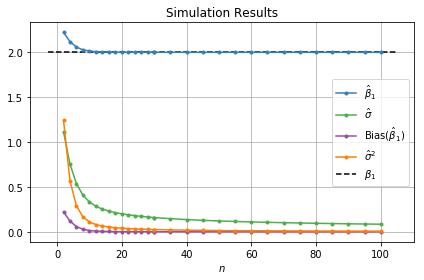

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
ax.grid(True)

ax.plot(bias_simulations['$n$'], bias_simulations['$\\hat{\\beta}_1$'],
        '.-', label='$\\hat{\\beta}_1$', c=plt.cm.Set1(1))
ax.plot(bias_simulations['$n$'], bias_simulations['$\\hat{\\sigma}$'],
        '.-', label='$\\hat{\\sigma}$', c=plt.cm.Set1(2))
ax.plot(bias_simulations['$n$'], bias_simulations['$\\hat{\\beta}_1$'] - 2,
        '.-', label='Bias($\\hat{\\beta}_1$)', c=plt.cm.Set1(3))
ax.plot(bias_simulations['$n$'], bias_simulations['$\\hat{\\sigma}$']**2,
        '.-', label='$\\hat{\\sigma}^2$', c=plt.cm.Set1(4))
ax.hlines(y=2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
          linestyles='--', label='$\\beta_1$')
ax.legend()
ax.set_xlabel('$n$')
ax.set_title('Simulation Results')
fig.tight_layout()
fig.savefig('p1_simulation_results.pdf', bbox_inches='tight')

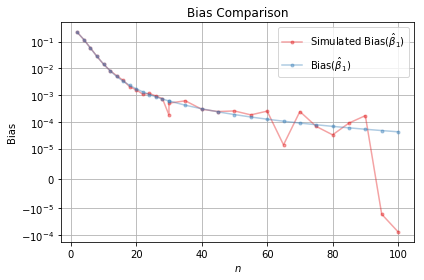

In [11]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
ax.grid(True)

ax.plot(bias_simulations['$n$'], bias_simulations['$\\hat{\\beta}_1$'] - 2,
        '.-', label='Simulated Bias($\\hat{\\beta}_1$)', c=plt.cm.Set1(0), alpha=0.4)
ax.plot(bias_simulations['$n$'], bias_simulations['$\mathbb{E}[\\hat{\\beta}_1]$'] - 2,
        '.-', label='Bias($\\hat{\\beta}_1$)', c=plt.cm.Set1(1), alpha=0.4)
ax.legend()
ax.set_title('Bias Comparison')
ax.set_xlabel('$n$')
ax.set_ylabel('Bias')
ax.set_yscale('symlog', linthreshy=1e-5)
fig.tight_layout()
fig.savefig('p1_bias_comparison.pdf', bbox_inches='tight')